In [2]:
!conda activate liveproject

In [9]:
from zipline.api import order_target, record, symbol
import matplotlib.pyplot as plt
from zipline import run_algorithm
import pandas as pd
import pandas_datareader.data as web

In [26]:
def initialize(context):
    context.i = 0
    context.asset = symbol('AAPL')


def handle_data(context, data):
    # Skip first 300 days to get full windows
    context.i += 1
    if context.i < 300:
        return

    # Compute averages
    # data.history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_mavg = data.history(context.asset, 'price', bar_count=100, frequency="1d").mean()
    long_mavg = data.history(context.asset, 'price', bar_count=300, frequency="1d").mean()

    # Trading logic
    if short_mavg > long_mavg:
        # order_target orders as many shares as needed to
        # achieve the desired number of shares.
        order_target(context.asset, 100)
    elif short_mavg < long_mavg:
        order_target(context.asset, 0)

    # Save values for later inspection
    record(AAPL=data.current(context.asset, 'price'),
           short_mavg=short_mavg,
           long_mavg=long_mavg)


def analyze(context, perf):
    fig = plt.figure(figsize=(12,12))
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('portfolio value in $')

    ax2 = fig.add_subplot(212)
    perf['AAPL'].plot(ax=ax2)
    perf[['short_mavg', 'long_mavg']].plot(ax=ax2)

    perf_trans = perf.loc[[t != [] for t in perf.transactions]]
    buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.loc[
        [t[0]['amount'] < 0 for t in perf_trans.transactions]]
    ax2.plot(buys.index, perf.short_mavg.loc[buys.index],
             '^', markersize=10, color='m')
    ax2.plot(sells.index, perf.short_mavg.loc[sells.index],
             'v', markersize=10, color='k')
    ax2.set_ylabel('price in $')
    plt.legend(loc=0)
    
    plt.show()

In [10]:
start = pd.Timestamp('2014')
end = pd.Timestamp('2018')

sp500 = web.DataReader('SP500', 'fred', start, end).SP500
benchmark_returns = sp500.pct_change()

result = run_algorithm(start=start.tz_localize('UTC'),
                       end=end.tz_localize('UTC'),
                       initialize=initialize,
                       handle_data=handle_data,
                       capital_base=100000,
                       benchmark_returns=benchmark_returns,
                       bundle='quandl',
                       data_frequency='daily')

/home/dratinox/miniconda3/envs/liveproject/lib/python3.8/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/dratinox/miniconda3/envs/liveproject/lib/python3.8/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/dratinox/miniconda3/envs/liveproject/lib/python3.8/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/dratinox/miniconda3/envs/liveproject/lib/python3.8/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/dratinox/miniconda3/envs/liveproject/lib/python3.8/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/hom

/home/dratinox/miniconda3/envs/liveproject/lib/python3.8/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/dratinox/miniconda3/envs/liveproject/lib/python3.8/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/dratinox/miniconda3/envs/liveproject/lib/python3.8/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/dratinox/miniconda3/envs/liveproject/lib/python3.8/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/dratinox/miniconda3/envs/liveproject/lib/python3.8/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/dratinox/miniconda3/envs/liveproject/lib/python3.8/site

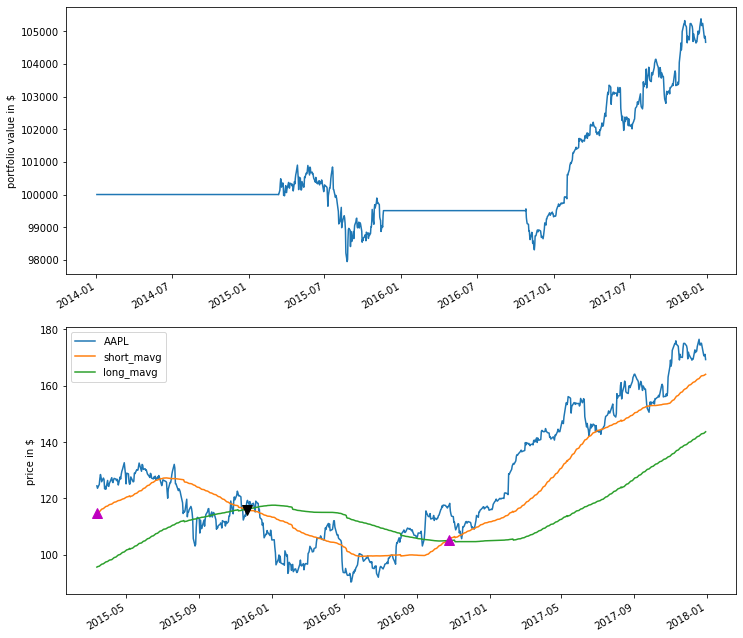

In [27]:
analyze(None, result)